In [53]:
%matplotlib ipympl

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import matplotlib.patheffects as pe

import networkx as nx
import matplotlib.patches as mpatches

from learning.data.nv_utils import collate_nv_data
from learning.data.stateflow_utils import get_active_edges_mask, collate_stateflow_data
from matplotlib.colors import LinearSegmentedColormap
from learning.model.nodevalue import NodeValueModel
from learning.data.nv_dataset import NodeValueDataset
from learning.data.load_utils import load_dicewars_data
import torch
import random
from learning.data.nv_utils import (
    extract_input, extract_output_target, collate_nv_data
)


In [ ]:
model_state = None
optim_state = None
latest_epoch = -1

with_dice_scatter = False

model_name = "nodevalue" + ("_no_dice" if not with_dice_scatter else "")
models_dir = f"learning/{model_name}_checkpoints" 

# Find the latest checkpoint file (with highest epoch number)
checkpoint_files = glob.glob(os.path.join(models_dir, f"{model_name}_*.pt"))
if checkpoint_files:
    # Extract epoch numbers from filenames
    epoch_nums = [int(f.split("_")[-1].split(".")[0]) for f in checkpoint_files]
    latest_epoch = max(epoch_nums)
    latest_checkpoint = os.path.join(models_dir, f"{model_name}_{latest_epoch:06}.pt")
    print(f"Loading latest checkpoint: {latest_checkpoint} (epoch {latest_epoch})")
    checkpoint = torch.load(latest_checkpoint, map_location=torch.device('cpu'))
    model_state = checkpoint["model_state"]
    optim_state = checkpoint["optim_state"]
else:
    print("No valid checkpoint files found")
    
start_epoch = latest_epoch + 1

Loading latest checkpoint: learning/nodevalue_checkpoints/nodevalue_000999.pt (epoch 999)


In [55]:
history_folder = "server/history/"

history_files = sorted(glob.glob(os.path.join(history_folder, "history_*.json")))
history_file = history_files[random.randint(0, len(history_files))]
history_data = json.load(open(history_file, "r"))
print(history_file)

server/history/history_00821_20250807_115933.json


In [56]:
node_value_model = NodeValueModel(with_dice_scatter=with_dice_scatter)
num_params = sum(p.numel() for p in node_value_model.parameters() if p.requires_grad)
print(f"Model created. Total trainable parameters: {num_params:,}")

Model created. Total trainable parameters: 4,244


In [57]:
if model_state is not None:
    node_value_model.load_state_dict(model_state)
    print(f"Model state loaded.")

Model state loaded.


In [58]:
players_color_map = { 
    i: color for i, color in enumerate([
        "#b37ffe",  # purple
        "#b3ff01",  # lime green
        "#009302",  # dark green
        "#ff7ffe",  # pink
        "#ff7f01",  # orange
        "#b3fffe",  # light cyan
        "#ffff01",  # yellow
        "#ff5858"   # light red
    ])    
}

In [ ]:
# Modify draw_state to pass the colorbar axis to draw_prediction
def draw_state(ax_base, ax_pred, history_data, index, colorbar_ax):
    if index < len(history_data["actions"]):
        action = history_data["actions"][index]
    else:
        action = {"move_made": False, "turn_end": False, "player": None}

    state = history_data["states"][index]
    teams = np.array(state["teams"])
    dice = np.array(state["dice"])
    node_positions = history_data["node_positions"]

    pos = {
        i: np.array([1, -1]) * np.array(node_pos)
        for i, node_pos in enumerate(node_positions)
    }
    xs, ys = zip(*pos.values())            # list of all x and y after shift
    left_pad  = 7.0                        # blank space on the left
    pad = 3.0                        # default
    ax_base.set_xlim(min(xs) - left_pad,  max(xs) + pad)
    ax_base.set_ylim(min(ys) - pad,  max(ys) + pad)
    ax_pred.set_xlim(min(xs) - left_pad,  max(xs) + pad)
    ax_pred.set_ylim(min(ys) - pad,  max(ys) + pad)

    graph = nx.from_numpy_array(np.array(history_data["adjacency"]))

    # 1) Build unique list and assign colors
    unique_teams = sorted(set(teams))  # preserves order
    cmap = plt.get_cmap("Set3")
    # 8 teams max
    color_map = { 
        i: color for i, color in enumerate([
            "#b37ffe",  # purple
            "#b3ff01",  # lime green
            "#009302",  # dark green
            "#ff7ffe",  # pink
            "#ff7f01",  # orange
            "#b3fffe",  # light cyan
            "#ffff01",  # yellow
            "#ff5858"   # light red
        ])    
    }

    # 2) Draw nodes using that mapping
    node_colors = [ color_map[t] for t in teams ]
    nx.draw_networkx_nodes(
        graph, pos,
        node_size=300,
        node_color=node_colors,
        edgecolors='black',
        ax=ax_base
    )

    # 3) Draw edges & labels
    # ----------------------------------------------------------
    # 3a) draw ALL ordinary edges (no arrows, default styling)
    #     keep the special edge OUT of this list
    # ----------------------------------------------------------
    if action["move_made"]:
        special_edge = (action["from"], action["to"])  # <-- pick the edge (u, v)
        dice_in_attack = dice[action["from"]] - 1
    else:
        special_edge = None

    ordinary_edges = [e for e in graph.edges() if e != special_edge]

    nx.draw_networkx_edges(
        graph, pos,
        edgelist=ordinary_edges,
        width=2,
        edge_color="grey",
        ax=ax_base
    )

    if action["move_made"]:
        # ----------------------------------------------------------
        # 3b) draw THAT ONE edge again, but with a styled ARROW
        # ----------------------------------------------------------
        nx.draw_networkx_edges(
            graph, pos,
            edgelist=[special_edge],
            width=3,
            edge_color="darkblue",
            arrows=True,                 # activate arrowheads
            arrowstyle="-|>",            # filled triangular head
            arrowsize=10,                # head size (points)
            ax=ax_base
        )

        # ----------------------------------------------------------
        # 3c) add a text label on (or near) that edge
        # ----------------------------------------------------------
        edge_lbl = {special_edge: dice_in_attack}   # label text - number of dice used in attack
        nx.draw_networkx_edge_labels(
            graph, pos,
            edge_labels=edge_lbl,
            font_color="darkblue",
            font_weight="bold",
            font_size=11,
            label_pos=0.35,              # 0 = src node, 1 = dst node
            bbox=dict(facecolor="white", edgecolor="none", pad=0.1),
            ax=ax_base,
            rotate=False
        )


    # ----------------------------------------------------------
    # 3d) create node labels
    # ----------------------------------------------------------
    label_dict = { i: d for i, d in enumerate(dice) }
    nx.draw_networkx_labels(
        graph, pos,
        labels=label_dict,
        font_size=12,
        font_weight='bold',
        ax=ax_base
    )

    # 4) Build and add legend
    legend_handles = [
        mpatches.Patch(
            facecolor=color_map[team], label=str(team), 
            edgecolor="black", linewidth=1
        )
        for team in unique_teams
    ]
    ax_base.legend(
        handles=legend_handles,
        title="Player",
        loc='upper left',      # Position the legend at the upper left
    )

    # 5) Add action description title
    title = f"State #{index} / {len(history_data['states']) - 1}"
    title += f"\nPlayer {action['player']}"

    if action["move_made"]:
        title = title \
            + f" attacked" \
            + f" from node {special_edge[0]} to {special_edge[1]}" \
            + f" with {dice_in_attack} dice"
    if action["turn_end"]:
        title += " ended the turn"

    ax_base.set_title(title, fontsize=16)

    # 6) Finalize
    #ax_base.axis('off')
    #ax_pred.axis('off')
    ax_base.format_coord = lambda x, y: ""      # suppress the live x-, y-readout
    ax_pred.format_coord = lambda x, y: ""     

    draw_prediction(ax_pred, graph, pos, history_data, index, node_value_model, colorbar_ax=colorbar_ax)


In [60]:
def draw_prediction(ax, graph, pos, history_data, index, model, colorbar_ax):
    data = NodeValueDataset(json_data=load_dicewars_data(
        json_data=history_data, drop_terminal_state=True),
        mix_players=False
    )[index]
    
    batch = collate_nv_data([data])

    edges_tn = batch["all_edges"]

    in_data = extract_input(batch, with_dice_scatter=with_dice_scatter)
    model.eval()
    with torch.no_grad():
        node_values = model.forward(*in_data, gather_logits=False)

    winner_logits = torch.zeros(
        8, dtype=node_values.dtype, device=node_values.device
    )
    winner_logits.index_add_(
        0,
        batch["player_ids"],
        node_values
    )
    winner_prob = torch.softmax(winner_logits, dim=0).numpy()
    node_values = node_values.numpy()

    vmax = 0.55  
    vmin = -0.15 
    # vmax = node_values.max()
    # vmin = node_values.min()

    # Set the title with normal black text
    ax.set_title("Node value prediction")
    
    legend_start = (0.01, 0.93)
    patch_size = 0.05
    # Add a colored patch to show the probability visually in the top left
    # I need to color edges with the values of their logit
    blue_red_cmap = LinearSegmentedColormap.from_list('BlueRed', ['red', 'yellow', 'green'])
    color = blue_red_cmap((node_values - vmin) / (vmax - vmin))

    nx.draw_networkx_nodes(
        graph, pos,
        node_size=300,
        node_color=node_values,
        cmap=blue_red_cmap, 
        vmin=vmin, 
        vmax=vmax,
        edgecolors='black',
        ax=ax
    )
    
    # Create a dictionary with node labels showing the logit values
    label_dict = {i: f"{val:.2f}" for i, val in enumerate(node_values)}
    
    # Add labels to the nodes
    nx.draw_networkx_labels(
        graph, pos,
        labels=label_dict,
        font_size=7,
        ax=ax
    )
    
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=edges_tn.numpy().T,
        width=2,
        edge_color="grey",
        ax=ax
    )

    step = 0.07
    for player_i in range(8):
        info_pos = (legend_start[0], legend_start[1] - step * (player_i + 1))
        patch = mpatches.Rectangle(
            info_pos,
            patch_size, patch_size, 
            transform=ax.transAxes,
            color=players_color_map[player_i],
            ec='black'
        )
        ax.add_patch(patch)

        ax.text(
            info_pos[0] + patch_size + 0.01, info_pos[1] + 0.02,
            f"{winner_prob[player_i]*100:.1f}%", transform=ax.transAxes
        )

    # Create a ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=blue_red_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    colorbar_ax.clear()
    colorbar = plt.colorbar(sm, cax=colorbar_ax, shrink=0.7, aspect=1)
    colorbar.set_label('Node Value Prediction')

In [61]:
def draw_prediction_no_dice_info(ax, graph, pos, history_data, index, model, colorbar_ax):
    data = NodeValueDataset(json_data=load_dicewars_data(
        json_data=history_data, drop_terminal_state=True),
        mix_players=False
    )[index]
    
    batch = collate_nv_data([data])

    edges_tn = batch["all_edges"]

    in_data = extract_input(batch, with_dice_scatter=with_dice_scatter)
    in_data = list(in_data)
    
    node_states = torch.zeros_like(in_data[0].clone())
    other_input = in_data[1:]
    n_states = node_states.shape[-2]
    n_runs = 100
    node_values = torch.zeros(
        n_states, dtype=node_states.dtype, device=node_states.device
    )
    for i in range(n_runs):
        node_states[:, -8:] = 0 
        node_idx = torch.arange(n_states)
        player_idx = torch.randint(-8, 0, (n_states,))
        player_value = torch.randint(
            1, 9, (n_states,), 
            dtype=node_states.dtype, device=node_states.device
        )
        node_states[node_idx, player_idx] = player_value
        
        model.eval()
        with torch.no_grad():
            node_values += model.forward(node_states, *other_input, gather_logits=False)
    
    node_values = node_values / n_runs
    
    winner_logits = torch.zeros(
        8, dtype=node_values.dtype, device=node_values.device
    )
    winner_logits.index_add_(
        0,
        batch["player_ids"],
        node_values
    )
    winner_prob = torch.softmax(winner_logits, dim=0).numpy()
    node_values = node_values.numpy()

    #vmax = 0.55  
    #vmin = -0.15 
    vmax = node_values.max()
    vmin = node_values.min()

    # Set the title with normal black text
    ax.set_title("Node value prediction")
    
    legend_start = (0.01, 0.93)
    patch_size = 0.05
    # Add a colored patch to show the probability visually in the top left
    # I need to color edges with the values of their logit
    blue_red_cmap = LinearSegmentedColormap.from_list('BlueRed', ['red', 'yellow', 'green'])
    color = blue_red_cmap((node_values - vmin) / (vmax - vmin))

    nx.draw_networkx_nodes(
        graph, pos,
        node_size=300,
        node_color=node_values,
        cmap=blue_red_cmap, 
        vmin=vmin, 
        vmax=vmax,
        edgecolors='black',
        ax=ax
    )
    
    # Create a dictionary with node labels showing the logit values
    label_dict = {i: f"{val:.2f}" for i, val in enumerate(node_values)}
    
    # Add labels to the nodes
    nx.draw_networkx_labels(
        graph, pos,
        labels=label_dict,
        font_size=7,
        ax=ax
    )
    
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=edges_tn.numpy().T,
        width=2,
        edge_color="grey",
        ax=ax
    )

    step = 0.07
    for player_i in range(8):
        info_pos = (legend_start[0], legend_start[1] - step * (player_i + 1))
        patch = mpatches.Rectangle(
            info_pos,
            patch_size, patch_size, 
            transform=ax.transAxes,
            color=players_color_map[player_i],
            ec='black'
        )
        ax.add_patch(patch)

        ax.text(
            info_pos[0] + patch_size + 0.01, info_pos[1] + 0.02,
            f"{winner_prob[player_i]*100:.1f}%", transform=ax.transAxes
        )

    # Create a ScalarMappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=blue_red_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    colorbar_ax.clear()
    colorbar = plt.colorbar(sm, cax=colorbar_ax, shrink=0.7, aspect=1)
    colorbar.set_label('Node Value Prediction')

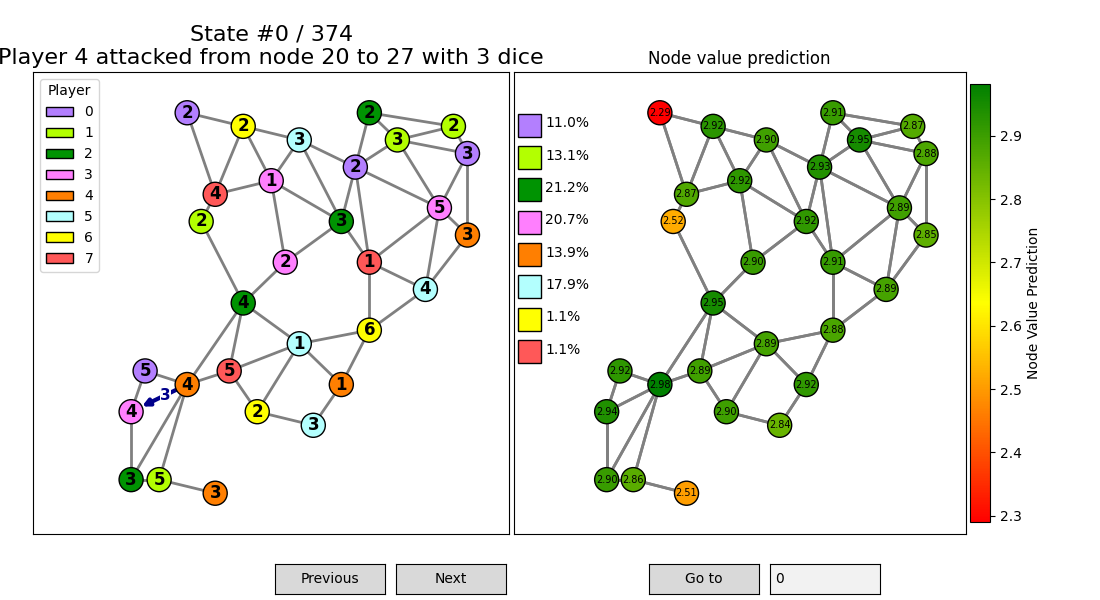

In [62]:
from matplotlib.widgets import Button, TextBox
from matplotlib.gridspec import GridSpec
from matplotlib.figure import SubplotParams


plt.close('all')

# Create figure with GridSpec for flexible layout
fig = plt.figure(figsize=(11, 6),
                 subplotpars=SubplotParams(left=0.03, right=0.9))
gs = GridSpec(40, 40, figure=fig)  # 40 columns for fine control

# Create axes: main plot, prediction plot, and colorbar
real_ax = fig.add_subplot(gs[:, :20])  # First 9 columns
predicted_ax = fig.add_subplot(gs[:, 20:-1])  # Next 9 columns
colorbar_ax = fig.add_subplot(gs[1:-1, -1:])  # Last column for colorbar

n_states = len(history_data["states"])
# Initialize with the first state
current_idx = 0
max_idx = len(history_data["states"]) - 1

# Function to update the plot
def update_plot(idx):
    real_ax.clear()
    predicted_ax.clear()
    draw_state(real_ax, predicted_ax, history_data, idx, colorbar_ax)
    text_box.set_val(str(idx))
    plt.draw()

# Initial plot
draw_state(real_ax, predicted_ax, history_data, current_idx, colorbar_ax)

# Add buttons for navigation and text input
prev_ax = plt.axes([0.25, 0.01, 0.1, 0.05])
next_ax = plt.axes([0.36, 0.01, 0.1, 0.05])  # Centered next button
go_ax = plt.axes([0.59, 0.01, 0.1, 0.05])
text_ax = plt.axes([0.7, 0.01, 0.1, 0.05])


# Create the text input for state index
text_box = TextBox(text_ax, label="", initial=str(current_idx))

# Go button handler
def go_click(event):
    global current_idx
    try:
        idx = int(text_box.text)
        # If the index is out of bounds, clamp it to valid range
        if idx < 0:
            current_idx = 0
        elif idx > max_idx:
            current_idx = max_idx
        else:
            current_idx = idx
    except ValueError:
        current_idx = 0

    text_box.set_val(str(current_idx))
    update_plot(current_idx)

go_button = Button(go_ax, 'Go to')
go_button.on_clicked(go_click)
prev_button = Button(prev_ax, 'Previous')
next_button = Button(next_ax, 'Next')

# Button click handlers
def prev_click(event):
    global current_idx
    current_idx = max(0, current_idx - 1)
    update_plot(current_idx)

def next_click(event):
    global current_idx
    current_idx = min(max_idx, current_idx + 1)
    update_plot(current_idx)

prev_button.on_clicked(prev_click)
next_button.on_clicked(next_click)

plt.show()